In [1]:
from pykrx import stock
from pykrx import bond
import pandas as pd
import math
import datetime as dt
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU



from itertools import cycle

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import seaborn as sns

# 변수선택법 시작

In [23]:
df = pd.read_csv('./stock_v05.csv', encoding='cp949')
df = df[df['업종']=='IT']
df.to_csv('./stock_v10.csv', encoding='cp949', index=False)

# 여기부터 삼성 전자만
stock_v10.csv 부터는 삼성전자만 있음

In [53]:
df = pd.read_csv('./stock_v10.csv', encoding='cp949')
df

,날짜,시가,고가,저가,종가,거래량,거래대금,등락률,BPS,PER,...,SMA,WMA,MOM,STCK,STCD,SIG,LWR,ADO,RSI,CCI
0,2018-04-27,53380,53640,52440,53000,606216,1.610000e+12,1.65,1156530,16.78,...,51398.0,51648.727273,3200.0,75.110274,67.630019,49220.000000,-11.428571,3.045836e+05,65.968830,154.639175
1,2018-05-04,53000,53900,51800,51900,39565391,2.080000e+12,-2.08,28126,8.65,...,51554.0,51740.000000,1560.0,77.943844,72.360099,49308.400000,-37.735849,-1.110982e+07,59.703911,114.860864
2,2018-05-08,52600,53200,51900,52600,23104720,1.220000e+12,1.35,28126,8.77,...,51816.0,51930.181818,2620.0,74.979722,76.011280,49492.064000,-25.896414,-1.420386e+07,62.166241,103.816070
3,2018-05-09,52600,52800,50900,50900,16128305,8.310000e+11,-3.23,28126,8.49,...,51770.0,51763.636364,-460.0,57.421724,70.115097,49668.381440,-64.102564,-1.931008e+07,53.600113,48.126533
4,2018-05-10,51700,51700,50600,51600,13905263,7.120000e+11,1.38,28126,8.60,...,51652.0,51732.727273,-1180.0,53.618574,62.006673,49837.646182,-49.145299,-1.602356e+07,56.272030,31.118215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,2023-03-27,62600,62800,62000,62100,11039331,6.870000e+11,-1.43,43611,10.75,...,60900.0,61461.818182,2100.0,88.372093,85.122952,59543.206437,-27.906977,7.331683e+06,55.120378,156.416465
1207,2023-03-28,62400,62900,62100,62900,11614118,7.260000e+11,1.29,43611,10.89,...,61290.0,61825.454545,3900.0,85.271318,88.302524,59768.614050,-9.302326,9.657889e+06,58.623100,159.107271
1208,2023-03-29,62500,62700,62200,62700,11216008,7.000000e+11,-0.32,43611,10.85,...,61580.0,62081.818182,2900.0,82.945736,85.529716,59980.497207,-13.953488,1.330026e+07,57.416624,128.923476
1209,2023-03-30,63700,63700,63100,63200,15684377,9.940000e+11,0.80,43611,10.94,...,61910.0,62376.363636,3300.0,88.701963,85.639672,60179.667375,-10.638298,1.025422e+07,59.652225,158.757062


C:\Users\magne\AppData\Local\Temp/ipykernel_2992/2409483188.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

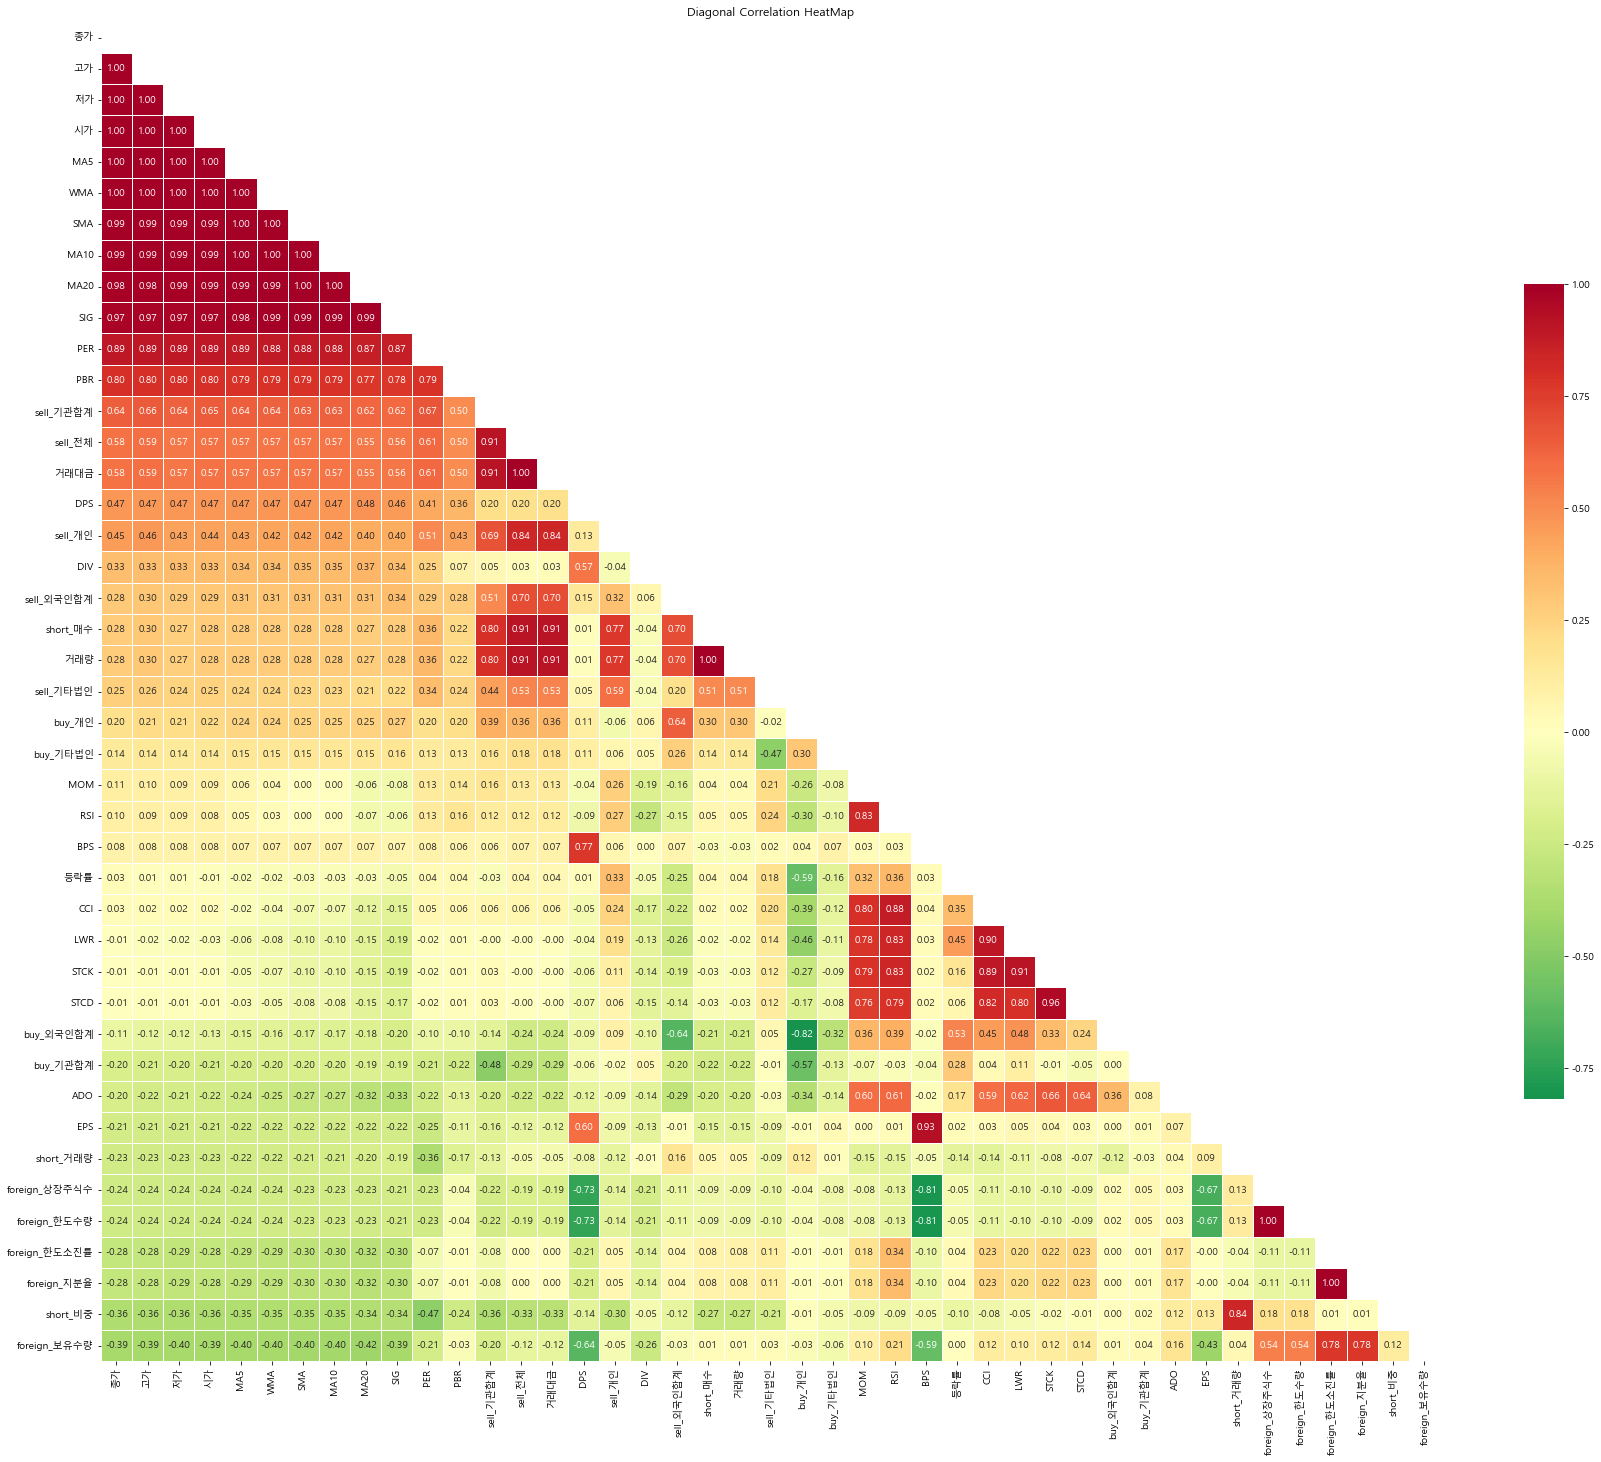

In [39]:
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


corr_matrix = df.corr()
corr_matrix = corr_matrix.sort_values(by = '종가', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(30, 30))
corr = df.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

상관관계 분석 결과 종가와 고가, 저가, 시가의 상관관계가 매우 높기때문에

다중공선성의 문제로 총 5가지 변수선택법을 이용해 종가, 고가, 저가, 시가 중 종가 예측에 가장 중요도가 높은 변수를 선택 후 

선택된 변수와 나머지 변수들을 5가지 변수선택법을 통해 중요도가 높은 변수를 뽑아내는 작업을 할 것임

In [54]:
from sklearn.model_selection import train_test_split


df1 = df.iloc[:,1:5]

X = df1
y = df1['종가']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

cols = X_train.columns

In [44]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [45]:
importance = rf.feature_importances_
feature = X_train.columns
importances = pd.DataFrame()
importances['feature'] = feature
importances['importances'] = importance
importances.sort_values('importances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)
importances

,feature,importances
0,종가,0.736854
1,저가,0.193999
2,고가,0.068924
3,시가,0.000222


In [46]:
from sklearn.feature_selection import RFE, RFECV

min_features_to_select = 1
step = 1
selector = RFECV(rf, step=step, cv=5, min_features_to_select=min_features_to_select)
selector = selector.fit(X_train, y_train)
selector.support_

array([False, False, False,  True])

In [47]:
a = selector.support_.reshape(1,-1)
df_a = pd.DataFrame(columns=X_train.columns, data=a)
df_a
true_columns = df_a.columns[df_a.iloc[0]].tolist()

print(true_columns)

['종가']


In [48]:
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVR
# X_train = np.array(X_train)
# y_train = np.array(y_train)
estimator = LinearSVR()
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)
selector.support_

C:\Users\magne\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\magne\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


array([False, False, False,  True])

In [49]:
a = selector.support_.reshape(1,-1)
df_a = pd.DataFrame(columns=X_train.columns, data=a)
df_a
true_columns = df_a.columns[df_a.iloc[0]].tolist()

print(true_columns)

['종가']


In [55]:
from sklearn.linear_model import Ridge, Lasso



ridge_alpha = 0.01
lasso_alpha = 0.001

rid = Ridge(alpha = ridge_alpha)
las = Lasso(alpha = lasso_alpha)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(np.array(X_train))
y_train=scaler.fit_transform(np.array(y_train).reshape(-1,1))

rid.fit(X_train,y_train)
las.fit(X_train,y_train)

X_train= scaler.inverse_transform(X_train)
y_train= scaler.inverse_transform(y_train)

rid.coef_, las.coef_

C:\Users\magne\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007635398579261852, tolerance: 0.005351701883416068
  model = cd_fast.enet_coordinate_descent(


(array([[-0.07261706,  0.12675836,  0.11922444,  0.82714755]]),
 array([0.        , 0.07310509, 0.28938665, 0.61932023]))

In [56]:
a = rid.coef_.reshape(1,-1)
df_a = pd.DataFrame(columns=cols, data=a)
df_a

aaa = df_a.columns.tolist()

fli=[]
coli=[]
for i, col in enumerate(aaa) :
    fli.append(col)
    coli.append(df_a.iloc[0,i])
    
dd = pd.DataFrame({'feature':fli, 'coef':coli})

dd.sort_values('coef', ascending=False, inplace=True)
dd.reset_index(drop=True, inplace=True)
dd

,feature,coef
0,종가,0.827148
1,고가,0.126758
2,저가,0.119224
3,시가,-0.072617


In [57]:
b = las.coef_.reshape(1,-1)
df_b = pd.DataFrame(columns=cols, data=b)
df_b
true_columns = df_b.columns[df_b.iloc[0] != 0].tolist()
print(true_columns)


['고가', '저가', '종가']


In [59]:
df['업종']

0       IT
1       IT
2       IT
3       IT
4       IT
        ..
1206    IT
1207    IT
1208    IT
1209    IT
1210    IT
Name: 업종, Length: 1211, dtype: object

In [60]:
df.drop(['업종','종목','날짜', '시가','고가','저가'], axis=1, inplace=True)
df

,종가,거래량,거래대금,등락률,BPS,PER,PBR,EPS,DIV,DPS,...,SMA,WMA,MOM,STCK,STCD,SIG,LWR,ADO,RSI,CCI
0,53000,606216,1.610000e+12,1.65,1156530,16.78,2.29,157967,1.08,28500,...,51398.0,51648.727273,3200.0,75.110274,67.630019,49220.000000,-11.428571,3.045836e+05,65.968830,154.639175
1,51900,39565391,2.080000e+12,-2.08,28126,8.65,1.85,5997,1.64,850,...,51554.0,51740.000000,1560.0,77.943844,72.360099,49308.400000,-37.735849,-1.110982e+07,59.703911,114.860864
2,52600,23104720,1.220000e+12,1.35,28126,8.77,1.87,5997,1.62,850,...,51816.0,51930.181818,2620.0,74.979722,76.011280,49492.064000,-25.896414,-1.420386e+07,62.166241,103.816070
3,50900,16128305,8.310000e+11,-3.23,28126,8.49,1.81,5997,1.67,850,...,51770.0,51763.636364,-460.0,57.421724,70.115097,49668.381440,-64.102564,-1.931008e+07,53.600113,48.126533
4,51600,13905263,7.120000e+11,1.38,28126,8.60,1.83,5997,1.65,850,...,51652.0,51732.727273,-1180.0,53.618574,62.006673,49837.646182,-49.145299,-1.602356e+07,56.272030,31.118215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,62100,11039331,6.870000e+11,-1.43,43611,10.75,1.42,5777,2.33,1444,...,60900.0,61461.818182,2100.0,88.372093,85.122952,59543.206437,-27.906977,7.331683e+06,55.120378,156.416465
1207,62900,11614118,7.260000e+11,1.29,43611,10.89,1.44,5777,2.30,1444,...,61290.0,61825.454545,3900.0,85.271318,88.302524,59768.614050,-9.302326,9.657889e+06,58.623100,159.107271
1208,62700,11216008,7.000000e+11,-0.32,43611,10.85,1.44,5777,2.30,1444,...,61580.0,62081.818182,2900.0,82.945736,85.529716,59980.497207,-13.953488,1.330026e+07,57.416624,128.923476
1209,63200,15684377,9.940000e+11,0.80,43611,10.94,1.45,5777,2.28,1444,...,61910.0,62376.363636,3300.0,88.701963,85.639672,60179.667375,-10.638298,1.025422e+07,59.652225,158.757062


In [61]:
from sklearn.model_selection import train_test_split

X = df
y = df['종가']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


In [62]:
cols = X_train.columns

In [63]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [64]:
importance = rf.feature_importances_
feature = X_train.columns
importances = pd.DataFrame()
importances['feature'] = feature
importances['importances'] = importance
importances.sort_values('importances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)
importances

,feature,importances
0,종가,9.733091e-01
1,MA5,1.562467e-02
2,WMA,7.907905e-03
3,PER,1.187126e-03
4,PBR,8.934862e-04
5,DIV,8.384195e-04
6,foreign_보유수량,6.995449e-05
7,RSI,3.273616e-05
8,foreign_지분율,1.904614e-05
9,MOM,1.020514e-05


In [65]:
from sklearn.feature_selection import RFE, RFECV

min_features_to_select = 10
step = 1
selector = RFECV(rf, step=step, cv=5, min_features_to_select=min_features_to_select)
selector = selector.fit(X_train, y_train)
selector.support_

array([ True, False, False, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True,  True, False, False,  True,  True, False, False, False,
       False, False,  True, False])

In [66]:
a = selector.support_.reshape(1,-1)
df_a = pd.DataFrame(columns=X_train.columns, data=a)
df_a
true_columns = df_a.columns[df_a.iloc[0]].tolist()

print(true_columns)

['종가', 'PER', 'PBR', 'DIV', 'foreign_보유수량', 'MA5', 'MA10', 'WMA', 'MOM', 'RSI']


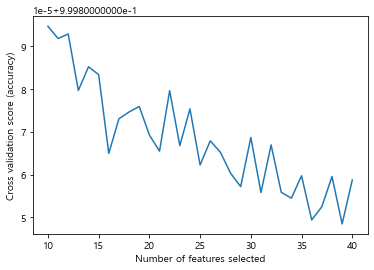

In [67]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(selector.grid_scores_)*step + min_features_to_select, step),
    selector.grid_scores_,
)

In [68]:
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVR
# X_train = np.array(X_train)
# y_train = np.array(y_train)
estimator = LinearSVR()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)
selector.support_

C:\Users\magne\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\magne\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\magne\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\magne\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\magne\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False,  True, False,
        True,  True,  True,  True,  True, False, False, False, False,
       False,  True, False, False])

In [69]:
a = selector.support_.reshape(1,-1)
df_a = pd.DataFrame(columns=X_train.columns, data=a)
df_a
true_columns = df_a.columns[df_a.iloc[0]].tolist()

print(true_columns)

['foreign_상장주식수', 'foreign_보유수량', 'foreign_한도수량', 'short_매수', 'MA5', 'MA10', 'MA20', 'SMA', 'WMA', 'ADO']


In [70]:
from sklearn.linear_model import Ridge, Lasso


ridge_alpha = 0.01
lasso_alpha = 0.001

rid = Ridge(alpha = ridge_alpha)
las = Lasso(alpha = lasso_alpha)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(np.array(X_train))
y_train=scaler.fit_transform(np.array(y_train).reshape(-1,1))

rid.fit(X_train,y_train)
las.fit(X_train,y_train)

X_train= scaler.inverse_transform(X_train)
y_train= scaler.inverse_transform(y_train)

rid.coef_, las.coef_

(array([[ 7.83423394e-01, -6.97130976e-03,  3.35955356e-03,
          1.50582978e-02, -6.91538967e-03,  1.58892960e-03,
          2.40853799e-03,  3.10973146e-03,  1.90459910e-03,
         -1.12129521e-02,  1.82973541e-03,  7.08193734e-04,
         -4.26327733e-03,  3.01011761e-03,  8.92069398e-03,
          5.49946336e-04,  2.72959608e-03,  7.11560203e-03,
          3.35955356e-03, -2.51862333e-03, -2.99890741e-03,
         -7.26291285e-04, -2.51862333e-03, -7.26291285e-04,
         -2.83586351e-03, -6.97130976e-03,  2.45351028e-03,
          9.78363526e-02,  4.06043492e-04,  4.84833433e-02,
          4.06043492e-04,  6.60830818e-02,  1.36220468e-02,
          1.68414064e-02, -1.58136514e-02, -1.78704216e-02,
         -5.79848036e-03,  1.92341453e-03,  1.23367024e-02,
          5.77540973e-03]]),
 array([ 0.90138106,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00170957,  0.        , -0.        ,  0.        ,  0.        ,
        -0.        ,  0.        , -0.        

In [71]:
a = rid.coef_.reshape(1,-1)
df_a = pd.DataFrame(columns=cols, data=a)
df_a

,종가,거래량,거래대금,등락률,BPS,PER,PBR,EPS,DIV,DPS,...,SMA,WMA,MOM,STCK,STCD,SIG,LWR,ADO,RSI,CCI
0,0.783423,-0.006971,0.00336,0.015058,-0.006915,0.001589,0.002409,0.00311,0.001905,-0.011213,...,0.000406,0.066083,0.013622,0.016841,-0.015814,-0.01787,-0.005798,0.001923,0.012337,0.005775


In [76]:
aaa = df_a.columns.tolist()

fli=[]
coli=[]
for i, col in enumerate(aaa) :
    fli.append(col)
    coli.append(df_a.iloc[0,i])
    
dd = pd.DataFrame({'feature':fli, 'coef':coli})

dd.sort_values('coef', ascending=False, inplace=True)
dd.reset_index(drop=True, inplace=True)
dd

,feature,coef
0,종가,0.783423
1,MA5,0.097836
2,WMA,0.066083
3,MA20,0.048483
4,STCK,0.016841
5,등락률,0.015058
6,MOM,0.013622
7,RSI,0.012337
8,sell_기관합계,0.008921
9,sell_외국인합계,0.007116


In [73]:

b = las.coef_.reshape(1,-1)
df_b = pd.DataFrame(columns=cols, data=b)
df_b
true_columns = df_b.columns[df_b.iloc[0] != 0].tolist()
print(true_columns)

['종가', 'PER', 'MA20', 'WMA']


RF feature_importances_ 기준 상위 10개 feature

종가, MA5, WMA, PER, PBR, DIV, foreign_보유수량, RSI, foreign_지분율, MOM, sell_외국인합계

RF RFECV 기준 10개 feature

종가, MA5, WMA, PER, PBR, DIV, foreign_보유수량, RSI, MOM, MA10

LinearSVR RFE 기준 10개 feature

MA5, WMA, foreign_보유수량, MA10, MA20, foreign_상장주식수, foreign_한도수량, short_매수, ADO, SMA

Lasso coef 기준 4개 feature

종가, PER, MA20, WMA

Ridge coef 기준 상위 10개 feature

종가, MA5, WMA, RSI, MOM, MA20, STCK, SIG, STCD, 등락률

------------------------------------------------------------------------
5개 포함 : WMA

4개 포함 : 종가, MA5

3개 포함 : PER, foreign_보유수량, RSI, MOM, MA20

2개 포함 : PBR, DIV, MA10

1개 포함 : foreign_지분율, sell_외국인합계, foreign_상장주식수, foreign_한도수량, short_매수, ADO, SMA, STCK, SIG, STCD, 등락률

# 가장 포함이 많이 된 상위 8개 변수 선택 완료
WMA, 종가, MA5, PER, foreign_보유수량, RSI, MOM, MA20

In [78]:
df = df.loc[:, ['종가','WMA','MA5','PER','foreign_보유수량','RSI','MOM','MA20']]
df

,종가,WMA,MA5,PER,foreign_보유수량,RSI,MOM,MA20
0,53000,51648.727273,51580.0,16.78,66883763,65.968830,3200.0,50022.0
1,51900,51740.000000,51580.0,8.65,3389738000,59.703911,1560.0,50190.0
2,52600,51930.181818,52008.0,8.77,3388514370,62.166241,2620.0,50414.0
3,50900,51763.636364,52108.0,8.49,3389966037,53.600113,-460.0,50613.0
4,51600,51732.727273,52000.0,8.60,3388367976,56.272030,-1180.0,50756.0
...,...,...,...,...,...,...,...,...
1206,62100,61461.818182,61760.0,10.75,3040249034,55.120378,2100.0,60675.0
1207,62900,61825.454545,62280.0,10.89,3040001094,58.623100,3900.0,60795.0
1208,62700,62081.818182,62600.0,10.85,3040243186,57.416624,2900.0,60900.0
1209,63200,62376.363636,62780.0,10.94,3036800280,59.652225,3300.0,61020.0


In [79]:
df.to_csv('./stock_v11.csv', encoding='cp949', index=False)

# 삼성전자 비시계열(SVR, RF), 시계열(LSTM, GRU, LSTM+GRU) 알고리즘에 여러 변수셋 적용 (2023.05.27)

1. 15일치 종가 + 1일전 선택된변수 다   (1개분석)

2. 15일치 종가 + 1일전 변수 하나씩  (7개분석)

3. 1일전 종가+선택된변수 다   (1개분석)


여기서 좋은 성과를 낸 변수 더미를 최종 변수로 선택


kb금융, 현대차, lg화학 도 위에 선택된 변수들로 알고리즘에 적용해보기



In [27]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')
df

,종가,WMA,MA5,PER,foreign_보유수량,RSI,MOM,MA20
0,53000,51648.72727,51580,16.78,66883763,65.968830,3200,50022.0
1,51900,51740.00000,51580,8.65,3389738000,59.703911,1560,50190.0
2,52600,51930.18182,52008,8.77,3388514370,62.166241,2620,50414.0
3,50900,51763.63636,52108,8.49,3389966037,53.600113,-460,50613.0
4,51600,51732.72727,52000,8.60,3388367976,56.272030,-1180,50756.0
...,...,...,...,...,...,...,...,...
1206,62100,61461.81818,61760,10.75,3040249034,55.120378,2100,60675.0
1207,62900,61825.45455,62280,10.89,3040001094,58.623100,3900,60795.0
1208,62700,62081.81818,62600,10.85,3040243186,57.416624,2900,60900.0
1209,63200,62376.36364,62780,10.94,3036800280,59.652225,3300,61020.0


In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))
print(sdf.shape)


max_val = max(df['종가'])
min_val = min(df['종가'])


# 재변환
# 원래데이터 = 변환된데이터 * (max_val - min_val) + min_val

(1211, 8)


In [29]:
training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (847, 8)
test_data:  (364, 8)


1. 15일치 종가 + 1일전 선택된변수 다

In [30]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = dataset[i+time_step-1, 1:]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

In [31]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [32]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (831, 22)
y_train:  (831,)
X_test:  (348, 22)
y_test (348,)


In [33]:
from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

In [34]:
train_predict.shape, y_train.shape

((831,), (831,))

In [35]:
train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


In [36]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

Train data RMSE:  1848.1071369897006
Test data RMSE:  2298.5805363766804


In [37]:
print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

Train data R2 score: 0.9838598481369347
Test data R2 score: 0.8893822288123084


In [38]:
svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)
svr_rmse, svr_r2

(2298.5805363766804, 0.8893822288123084)

In [39]:
# 알고리즘 적용 전 셋팅!!!!!!!!!!

df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = dataset[i+time_step-1, 1:]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (831, 22)
y_train:  (831,)
X_test:  (348, 22)
y_test (348,)


In [40]:
from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

In [41]:
train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val

In [42]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

Train data RMSE:  372.6424452442216
Test data RMSE:  1683.6880197059102


In [43]:
print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

Train data R2 score: 0.9993437973644831
Test data R2 score: 0.9406489102821052


In [44]:
rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)
rf_rmse, rf_r2

(1683.6880197059102, 0.9406489102821052)

In [45]:
# 알고리즘 적용 전 셋팅!!!!!!!!!!

df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = dataset[i+time_step-1, 1:]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (831, 22)
y_train:  (831,)
X_test:  (348, 22)
y_test (348,)


In [46]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(22,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

X_train:  (831, 22, 1)
X_test:  (348, 22, 1)
Epoch 1/10
167/167 [==============================] - 22s 68ms/step - loss: 0.0063 - val_loss: 8.0470e-04
Epoch 2/10
167/167 [==============================] - 10s 59ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 3/10
167/167 [==============================] - 11s 65ms/step - loss: 8.9451e-04 - val_loss: 5.9858e-04
Epoch 4/10
167/167 [==============================] - 10s 61ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 5/10
167/167 [==============================] - 10s 61ms/step - loss: 8.5341e-04 - val_loss: 0.0011
Epoch 6/10
167/167 [==============================] - 11s 63ms/step - loss: 8.9278e-04 - val_loss: 0.0029
Epoch 7/10
167/167 [==============================] - 10s 60ms/step - loss: 9.5080e-04 - val_loss: 0.0024
Epoch 8/10
167/167 [==============================] - 10s 62ms/step - loss: 8.5680e-04 - val_loss: 0.0019
Epoch 9/10
167/167 [==============================] - 10s 60ms/step - loss: 7.0793e-04 - val_loss: 0.0013
Epoch

((831, 1), (348, 1))

In [47]:
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)
gru_rmse, gru_r2

Train data RMSE:  1953.7104710625872
Test data RMSE:  3274.871623307133
Train data R2 score: 0.9819626082964134
Test data R2 score: 0.7754598470907459


(3274.871623307133, 0.7754598470907459)

In [48]:
# 알고리즘 적용 전 셋팅!!!!!!!!!!


df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = dataset[i+time_step-1, 1:]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(22,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)
lstmgru_rmse, lstmgru_r2

Epoch 1/10
167/167 [==============================] - 27s 85ms/step - loss: 0.0075 - val_loss: 7.7104e-04
Epoch 2/10
167/167 [==============================] - 12s 73ms/step - loss: 8.2115e-04 - val_loss: 0.0011
Epoch 3/10
167/167 [==============================] - 12s 71ms/step - loss: 0.0012 - val_loss: 6.5236e-04
Epoch 4/10
167/167 [==============================] - 12s 71ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 5/10
167/167 [==============================] - 12s 73ms/step - loss: 9.0751e-04 - val_loss: 7.0925e-04
Epoch 6/10
167/167 [==============================] - 12s 75ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/10
167/167 [==============================] - 12s 75ms/step - loss: 9.5808e-04 - val_loss: 0.0014
Epoch 8/10
167/167 [==============================] - 12s 70ms/step - loss: 8.9938e-04 - val_loss: 6.0654e-04
Epoch 9/10
167/167 [==============================] - 12s 71ms/step - loss: 8.2646e-04 - val_loss: 0.0011
Epoch 10/10
167/167 [=========================

(2481.1025391021417, 0.8711172244493226)

In [49]:
# 알고리즘 적용 전 셋팅!!!!!!!!!!


df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = dataset[i+time_step-1, 1:]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(22,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
lstm_rmse, lstm_r2

Epoch 1/10
167/167 [==============================] - 16s 47ms/step - loss: 0.0139 - val_loss: 0.0014
Epoch 2/10
167/167 [==============================] - 6s 34ms/step - loss: 7.8680e-04 - val_loss: 7.7112e-04
Epoch 3/10
167/167 [==============================] - 6s 36ms/step - loss: 7.1246e-04 - val_loss: 8.0077e-04
Epoch 4/10
167/167 [==============================] - 6s 36ms/step - loss: 6.6941e-04 - val_loss: 7.7505e-04
Epoch 5/10
167/167 [==============================] - 6s 37ms/step - loss: 6.9385e-04 - val_loss: 7.4549e-04
Epoch 6/10
167/167 [==============================] - 6s 35ms/step - loss: 6.2191e-04 - val_loss: 0.0016
Epoch 7/10
167/167 [==============================] - 6s 38ms/step - loss: 7.7541e-04 - val_loss: 0.0014
Epoch 8/10
167/167 [==============================] - 6s 35ms/step - loss: 6.2924e-04 - val_loss: 0.0013
Epoch 9/10
167/167 [==============================] - 6s 38ms/step - loss: 6.0166e-04 - val_loss: 0.0016
Epoch 10/10
167/167 [=====================

(1623.6215979007866, 0.9448081319716822)

In [50]:
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison1 = pd.DataFrame(data)

comparison1.sort_values(['r2'], ascending=False)

,algorithm,rmse,r2
2,lstm,1623.621598,0.944808
1,rf,1683.688020,0.940649
0,svr,2298.580536,0.889382
4,lstmgru,2481.102539,0.871117
3,gru,3274.871623,0.775460


2. 15일치 종가 + 1일전 변수 하나씩  (7개분석)

2-1. 15일치 종가 + WMA

2-2. 15일치 종가 + MA5

2-3. 15일치 종가 + MA20

2-4. 15일치 종가 + PER

2-5. 15일치 종가 + foreign_보유수량

2-6. 15일치 종가 + RSI

2-7. 15일치 종가 + MOM

# 2-1. 15일치 종가 + WMA

In [51]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 1]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val

print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))
print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))
svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)
svr_rmse, svr_r2

Train data RMSE:  1784.8447845305964
Test data RMSE:  1516.1449824584313
Train data R2 score: 0.9849459193839979
Test data R2 score: 0.9518732073208086


(1516.1449824584313, 0.9518732073208086)

In [52]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 1]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val

print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))
print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)
rf_rmse, rf_r2

Train data RMSE:  395.1649890006566
Test data RMSE:  1810.2141717767042
Train data R2 score: 0.9992620783575259
Test data R2 score: 0.9313934824789699


(1810.2141717767042, 0.9313934824789699)

In [53]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = [dataset[i+time_step-1, 1]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(16,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)
gru_rmse, gru_r2

Epoch 1/10
167/167 [==============================] - 20s 60ms/step - loss: 0.0126 - val_loss: 9.3409e-04
Epoch 2/10
167/167 [==============================] - 8s 48ms/step - loss: 0.0010 - val_loss: 5.9088e-04
Epoch 3/10
167/167 [==============================] - 8s 48ms/step - loss: 8.3176e-04 - val_loss: 4.7346e-04
Epoch 4/10
167/167 [==============================] - 9s 51ms/step - loss: 7.6889e-04 - val_loss: 4.6275e-04
Epoch 5/10
167/167 [==============================] - 8s 49ms/step - loss: 8.8037e-04 - val_loss: 5.4807e-04
Epoch 6/10
167/167 [==============================] - 8s 46ms/step - loss: 8.1272e-04 - val_loss: 4.9297e-04
Epoch 7/10
167/167 [==============================] - 7s 41ms/step - loss: 6.2794e-04 - val_loss: 4.0471e-04
Epoch 8/10
167/167 [==============================] - 8s 47ms/step - loss: 5.7271e-04 - val_loss: 5.4430e-04
Epoch 9/10
167/167 [==============================] - 9s 52ms/step - loss: 5.4656e-04 - val_loss: 3.4412e-04
Epoch 10/10
167/167 [=====

(994.3787629731722, 0.979298151080055)

In [54]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 1]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)
lstmgru_rmse, lstmgru_r2

Epoch 1/10
167/167 [==============================] - 25s 73ms/step - loss: 0.0102 - val_loss: 0.0018
Epoch 2/10
167/167 [==============================] - 10s 58ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/10
167/167 [==============================] - 10s 58ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 4/10
167/167 [==============================] - 10s 58ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/10
167/167 [==============================] - 10s 63ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 6/10
167/167 [==============================] - 10s 59ms/step - loss: 0.0017 - val_loss: 8.1545e-04
Epoch 7/10
167/167 [==============================] - 10s 60ms/step - loss: 0.0014 - val_loss: 6.7834e-04
Epoch 8/10
167/167 [==============================] - 10s 59ms/step - loss: 0.0013 - val_loss: 7.3922e-04
Epoch 9/10
167/167 [==============================] - 10s 61ms/step - loss: 9.5531e-04 - val_loss: 6.7523e-04
Epoch 10/10
167/167 [==============================] - 10s 60m

(1214.9242662196364, 0.9690967705186394)

In [55]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 1]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
lstm_rmse, lstm_r2

Epoch 1/10
167/167 [==============================] - 12s 36ms/step - loss: 0.0090 - val_loss: 0.0020
Epoch 2/10
167/167 [==============================] - 5s 33ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/10
167/167 [==============================] - 5s 31ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/10
167/167 [==============================] - 4s 23ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/10
167/167 [==============================] - 5s 28ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/10
167/167 [==============================] - 5s 28ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 7/10
167/167 [==============================] - 5s 30ms/step - loss: 0.0014 - val_loss: 9.8968e-04
Epoch 8/10
167/167 [==============================] - 5s 29ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 9/10
167/167 [==============================] - 5s 31ms/step - loss: 0.0014 - val_loss: 8.6874e-04
Epoch 10/10
167/167 [==============================] - 5s 29ms/step - loss: 0.0013

(1757.6607830120445, 0.9353191706964863)

In [56]:
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison2 = pd.DataFrame(data)

comparison2.sort_values(['r2'], ascending=False)

,algorithm,rmse,r2
3,gru,994.378763,0.979298
4,lstmgru,1214.924266,0.969097
0,svr,1516.144982,0.951873
2,lstm,1757.660783,0.935319
1,rf,1810.214172,0.931393


# 2-2. 15일치 종가 + MA5

In [57]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 2]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val

print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))
print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))
svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)
svr_rmse, svr_r2

Train data RMSE:  1781.621403786059
Test data RMSE:  1468.6334075601076
Train data R2 score: 0.9850002447982462
Test data R2 score: 0.9548422536343388


(1468.6334075601076, 0.9548422536343388)

In [58]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 2]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val

print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))
print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)
rf_rmse, rf_r2

Train data RMSE:  389.0891261325718
Test data RMSE:  1736.3025758944034
Train data R2 score: 0.9992845957500134
Test data R2 score: 0.9368815576141347


(1736.3025758944034, 0.9368815576141347)

In [59]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = [dataset[i+time_step-1, 2]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(16,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)
gru_rmse, gru_r2

Epoch 1/10
167/167 [==============================] - 20s 61ms/step - loss: 0.0084 - val_loss: 5.4270e-04
Epoch 2/10
167/167 [==============================] - 8s 49ms/step - loss: 8.7843e-04 - val_loss: 4.8864e-04
Epoch 3/10
167/167 [==============================] - 8s 50ms/step - loss: 8.9637e-04 - val_loss: 0.0013
Epoch 4/10
167/167 [==============================] - 8s 50ms/step - loss: 7.1081e-04 - val_loss: 9.2335e-04
Epoch 5/10
167/167 [==============================] - 8s 49ms/step - loss: 6.0524e-04 - val_loss: 4.9917e-04
Epoch 6/10
167/167 [==============================] - 8s 49ms/step - loss: 6.4810e-04 - val_loss: 4.3699e-04
Epoch 7/10
167/167 [==============================] - 8s 49ms/step - loss: 6.4768e-04 - val_loss: 4.7819e-04
Epoch 8/10
167/167 [==============================] - 8s 50ms/step - loss: 6.1958e-04 - val_loss: 3.6093e-04
Epoch 9/10
167/167 [==============================] - 8s 50ms/step - loss: 6.1081e-04 - val_loss: 4.8228e-04
Epoch 10/10
167/167 [=====

(1028.862183241916, 0.9778374431241529)

In [60]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 2]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)
lstmgru_rmse, lstmgru_r2

Epoch 1/10
167/167 [==============================] - 25s 77ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 2/10
167/167 [==============================] - 10s 62ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 3/10
167/167 [==============================] - 10s 60ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/10
167/167 [==============================] - 10s 60ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 5/10
167/167 [==============================] - 10s 63ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/10
167/167 [==============================] - 10s 59ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/10
167/167 [==============================] - 10s 58ms/step - loss: 0.0012 - val_loss: 5.9984e-04
Epoch 8/10
167/167 [==============================] - 10s 57ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 9/10
167/167 [==============================] - 10s 61ms/step - loss: 0.0010 - val_loss: 9.5902e-04
Epoch 10/10
167/167 [==============================] - 10s 60ms/step - los

(1279.8211292960748, 0.9657071163728085)

In [61]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 2]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

print("Train data R2 score:", r2_score(y_train,train_predict))
print("Test data R2 score:", r2_score(y_test,test_predict))

lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
lstm_rmse, lstm_r2

Epoch 1/10
167/167 [==============================] - 12s 37ms/step - loss: 0.0121 - val_loss: 0.0014
Epoch 2/10
167/167 [==============================] - 5s 29ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/10
167/167 [==============================] - 5s 29ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 4/10
167/167 [==============================] - 4s 26ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/10
167/167 [==============================] - 5s 29ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 6/10
167/167 [==============================] - 5s 31ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/10
167/167 [==============================] - 5s 29ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/10
167/167 [==============================] - 5s 31ms/step - loss: 0.0011 - val_loss: 7.9598e-04
Epoch 9/10
167/167 [==============================] - 5s 29ms/step - loss: 0.0011 - val_loss: 8.3464e-04
Epoch 10/10
167/167 [==============================] - 5s 31ms/step - loss: 9.3556

(1247.9505404476813, 0.9673937990464785)

In [62]:
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison3 = pd.DataFrame(data)

comparison3.sort_values(['r2'], ascending=False)

,algorithm,rmse,r2
3,gru,1028.862183,0.977837
2,lstm,1247.950540,0.967394
4,lstmgru,1279.821129,0.965707
0,svr,1468.633408,0.954842
1,rf,1736.302576,0.936882


# 2-3 15일치 종가 + PER

In [63]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 3]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 3]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = [dataset[i+time_step-1, 3]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(16,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 3]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 3]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison4 = pd.DataFrame(data)

comparison4.sort_values(['r2'], ascending=False)


Epoch 1/10
167/167 [==============================] - 20s 59ms/step - loss: 0.0080 - val_loss: 6.2463e-04
Epoch 2/10
167/167 [==============================] - 8s 50ms/step - loss: 9.1700e-04 - val_loss: 0.0011
Epoch 3/10
167/167 [==============================] - 8s 49ms/step - loss: 9.0821e-04 - val_loss: 6.1491e-04
Epoch 4/10
167/167 [==============================] - 8s 48ms/step - loss: 8.6701e-04 - val_loss: 0.0010
Epoch 5/10
167/167 [==============================] - 8s 46ms/step - loss: 9.7510e-04 - val_loss: 0.0011
Epoch 6/10
167/167 [==============================] - 8s 47ms/step - loss: 0.0011 - val_loss: 8.1979e-04
Epoch 7/10
167/167 [==============================] - 8s 48ms/step - loss: 8.5974e-04 - val_loss: 5.0217e-04
Epoch 8/10
167/167 [==============================] - 8s 49ms/step - loss: 6.8157e-04 - val_loss: 6.7054e-04
Epoch 9/10
167/167 [==============================] - 8s 48ms/step - loss: 6.0737e-04 - val_loss: 4.3981e-04
Epoch 10/10
167/167 [=================

,algorithm,rmse,r2
3,gru,1155.830176,0.972030
2,lstm,1549.385017,0.949740
1,rf,1683.742092,0.940645
4,lstmgru,2244.472350,0.894529
0,svr,2335.266793,0.885823


# 2-4. 15일치 종가 + foreign_보유수량

In [64]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 4]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 4]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = [dataset[i+time_step-1, 4]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(16,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 4]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 4]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison5 = pd.DataFrame(data)

comparison5.sort_values(['r2'], ascending=False)


Epoch 1/10
167/167 [==============================] - 20s 60ms/step - loss: 0.0040 - val_loss: 8.4918e-04
Epoch 2/10
167/167 [==============================] - 8s 51ms/step - loss: 0.0013 - val_loss: 6.2296e-04
Epoch 3/10
167/167 [==============================] - 9s 52ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 4/10
167/167 [==============================] - 8s 49ms/step - loss: 8.2474e-04 - val_loss: 7.7393e-04
Epoch 5/10
167/167 [==============================] - 8s 49ms/step - loss: 8.7183e-04 - val_loss: 4.7497e-04
Epoch 6/10
167/167 [==============================] - 8s 49ms/step - loss: 7.2311e-04 - val_loss: 6.8568e-04
Epoch 7/10
167/167 [==============================] - 8s 49ms/step - loss: 7.5575e-04 - val_loss: 5.6913e-04
Epoch 8/10
167/167 [==============================] - 8s 49ms/step - loss: 7.6722e-04 - val_loss: 6.4695e-04
Epoch 9/10
167/167 [==============================] - 8s 48ms/step - loss: 7.4928e-04 - val_loss: 7.5465e-04
Epoch 10/10
167/167 [=============

,algorithm,rmse,r2
4,lstmgru,1300.337953,0.964599
3,gru,1310.046003,0.964068
2,lstm,1395.460583,0.959230
0,svr,1543.084752,0.950148
1,rf,1770.314542,0.934385


# 2-5. 15일치 종가 + RSI

In [65]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 5]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 5]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = [dataset[i+time_step-1, 5]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(16,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 5]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 5]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison6 = pd.DataFrame(data)

comparison6.sort_values(['r2'], ascending=False)


Epoch 1/10
167/167 [==============================] - 20s 57ms/step - loss: 0.0130 - val_loss: 5.6662e-04
Epoch 2/10
167/167 [==============================] - 8s 50ms/step - loss: 7.3949e-04 - val_loss: 4.9618e-04
Epoch 3/10
167/167 [==============================] - 8s 48ms/step - loss: 8.0685e-04 - val_loss: 0.0013
Epoch 4/10
167/167 [==============================] - 8s 50ms/step - loss: 7.6149e-04 - val_loss: 4.6292e-04
Epoch 5/10
167/167 [==============================] - 8s 50ms/step - loss: 6.7330e-04 - val_loss: 4.6985e-04
Epoch 6/10
167/167 [==============================] - 8s 50ms/step - loss: 6.6210e-04 - val_loss: 4.4816e-04
Epoch 7/10
167/167 [==============================] - 8s 48ms/step - loss: 0.0011 - val_loss: 5.7312e-04
Epoch 8/10
167/167 [==============================] - 8s 50ms/step - loss: 7.0610e-04 - val_loss: 0.0014
Epoch 9/10
167/167 [==============================] - 8s 49ms/step - loss: 8.5172e-04 - val_loss: 5.3943e-04
Epoch 10/10
167/167 [=============

,algorithm,rmse,r2
4,lstmgru,1094.338342,0.974927
3,gru,1712.218244,0.938620
1,rf,1742.758564,0.936411
0,svr,2165.779276,0.901795
2,lstm,2452.116410,0.874111


# 2-6. 15일치 종가 + MOM

In [66]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 6]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 6]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = [dataset[i+time_step-1, 6]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(16,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 6]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 6]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison7 = pd.DataFrame(data)

comparison7.sort_values(['r2'], ascending=False)


Epoch 1/10
167/167 [==============================] - 20s 63ms/step - loss: 0.0093 - val_loss: 6.0103e-04
Epoch 2/10
167/167 [==============================] - 8s 48ms/step - loss: 8.7184e-04 - val_loss: 6.6320e-04
Epoch 3/10
167/167 [==============================] - 8s 49ms/step - loss: 6.9714e-04 - val_loss: 4.9542e-04
Epoch 4/10
167/167 [==============================] - 9s 51ms/step - loss: 8.0924e-04 - val_loss: 5.7298e-04
Epoch 5/10
167/167 [==============================] - 8s 50ms/step - loss: 7.6025e-04 - val_loss: 6.8115e-04
Epoch 6/10
167/167 [==============================] - 8s 48ms/step - loss: 7.9778e-04 - val_loss: 4.3770e-04
Epoch 7/10
167/167 [==============================] - 8s 49ms/step - loss: 7.7304e-04 - val_loss: 5.6703e-04
Epoch 8/10
167/167 [==============================] - 8s 50ms/step - loss: 6.1680e-04 - val_loss: 4.2275e-04
Epoch 9/10
167/167 [==============================] - 8s 50ms/step - loss: 7.8794e-04 - val_loss: 0.0043
Epoch 10/10
167/167 [=====

,algorithm,rmse,r2
2,lstm,1302.044425,0.964506
0,svr,1621.445331,0.944956
4,lstmgru,1739.491690,0.936649
1,rf,1796.439719,0.932434
3,gru,2096.978495,0.907935


# 2-7. 15일치 종가 + MA20

In [84]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 7]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 7]] # 단일값 이기에 배열로 변환후 concatenate 수행
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        b = [dataset[i+time_step-1, 7]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(16,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 7]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        b = [dataset[i+time_step-1, 7]]
        data = np.concatenate((a, b)) 
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(16,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison8 = pd.DataFrame(data)

comparison8.sort_values(['r2'], ascending=False)


Epoch 1/10
167/167 [==============================] - 8s 22ms/step - loss: 0.0086 - val_loss: 7.6805e-04
Epoch 2/10
167/167 [==============================] - 3s 16ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 3/10
167/167 [==============================] - 3s 16ms/step - loss: 9.5982e-04 - val_loss: 7.6481e-04
Epoch 4/10
167/167 [==============================] - 3s 16ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5/10
167/167 [==============================] - 3s 17ms/step - loss: 8.6925e-04 - val_loss: 6.5642e-04
Epoch 6/10
167/167 [==============================] - 3s 16ms/step - loss: 9.1351e-04 - val_loss: 4.8519e-04
Epoch 7/10
167/167 [==============================] - 3s 16ms/step - loss: 7.1437e-04 - val_loss: 5.3173e-04
Epoch 8/10
167/167 [==============================] - 3s 19ms/step - loss: 9.2791e-04 - val_loss: 4.3979e-04
Epoch 9/10
167/167 [==============================] - 3s 17ms/step - loss: 6.3598e-04 - val_loss: 6.1321e-04
Epoch 10/10
167/167 [==================

,algorithm,rmse,r2
3,gru,1012.289214,0.978546
4,lstmgru,1432.395292,0.957043
0,svr,1709.434841,0.938820
1,rf,1795.600022,0.932497
2,lstm,1797.411065,0.932361


# 3. 1일전 종가+선택된변수 다 

In [6]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]


def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

#X_train.shape, y_train.shape, X_test.shape, y_test.shape


from sklearn.svm import SVR



svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
svr_r2 = r2_score(y_test,test_predict)

df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]


def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict.reshape(-1,1)
test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
rf_r2 = r2_score(y_test,test_predict)

df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]


def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(8,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
gru_r2 = r2_score(y_test,test_predict)

df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]


def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(8,1), activation='tanh'))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val


lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstmgru_r2 = r2_score(y_test,test_predict)

df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]


def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(16, return_sequences=True,input_shape=(8,1), activation='tanh'))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


train_predict = train_predict*(max_val-min_val) + min_val

y_train = y_train.reshape(-1,1)
y_train = y_train*(max_val-min_val) + min_val

test_predict = test_predict*(max_val-min_val) + min_val

y_test = y_test.reshape(-1,1)
y_test = y_test*(max_val-min_val) + min_val



lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
lstm_r2 = r2_score(y_test,test_predict)
algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
        'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
        'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

comparison9 = pd.DataFrame(data)

comparison9.sort_values(['r2'], ascending=False)


Epoch 1/10
169/169 [==============================] - 11s 23ms/step - loss: 0.0223 - val_loss: 0.0083
Epoch 2/10
169/169 [==============================] - 3s 15ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 3/10
169/169 [==============================] - 3s 15ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 4/10
169/169 [==============================] - 2s 14ms/step - loss: 9.5070e-04 - val_loss: 0.0012
Epoch 5/10
169/169 [==============================] - 3s 15ms/step - loss: 9.5671e-04 - val_loss: 0.0021
Epoch 6/10
169/169 [==============================] - 2s 14ms/step - loss: 8.8187e-04 - val_loss: 0.0036
Epoch 7/10
169/169 [==============================] - 3s 15ms/step - loss: 9.4179e-04 - val_loss: 0.0014
Epoch 8/10
169/169 [==============================] - 2s 14ms/step - loss: 8.3104e-04 - val_loss: 6.3875e-04
Epoch 9/10
169/169 [==============================] - 2s 13ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 10/10
169/169 [==============================] - 3s 15ms/ste

,algorithm,rmse,r2
1,rf,1570.000946,0.947665
2,lstm,1784.183619,0.932412
3,gru,2125.581252,0.904072
0,svr,2793.364893,0.834329
4,lstmgru,3895.281508,0.677843


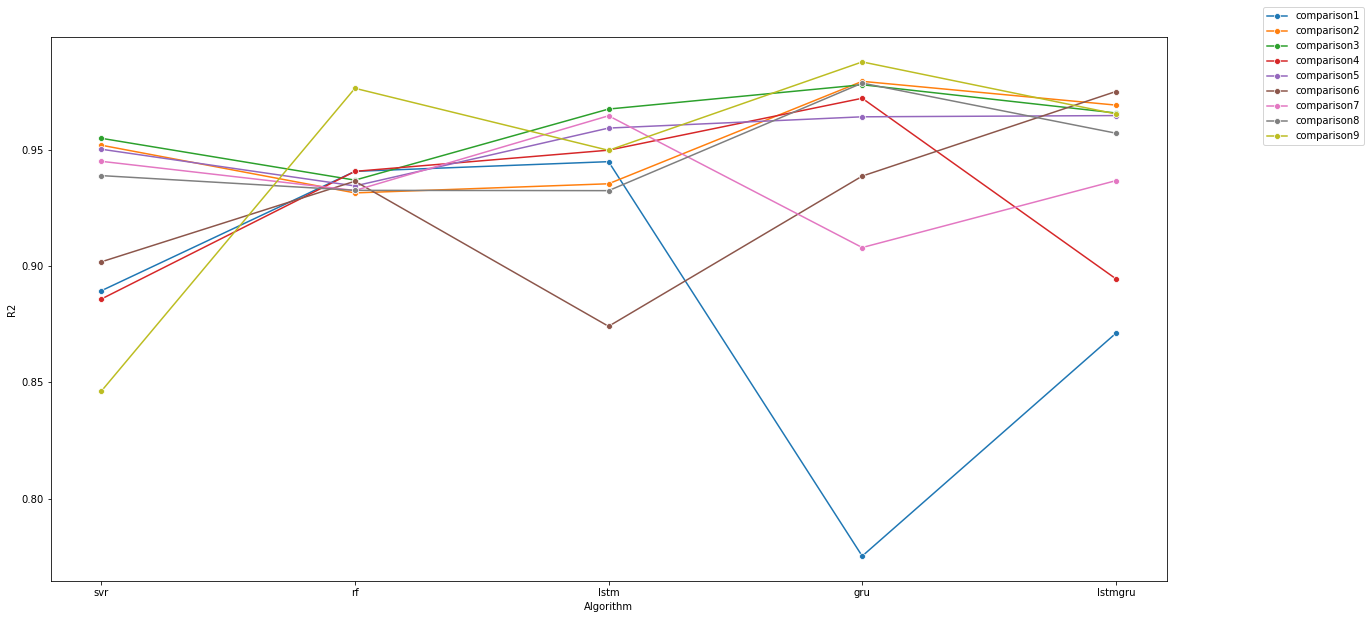

In [99]:
# 그래프 그리기

plt.figure(figsize=(20, 10))
sns.lineplot(x='algorithm', y='r2', data=comparison1, marker='o', label='comparison1')
sns.lineplot(x='algorithm', y='r2', data=comparison2, marker='o', label='comparison2')
sns.lineplot(x='algorithm', y='r2', data=comparison3, marker='o', label='comparison3')
sns.lineplot(x='algorithm', y='r2', data=comparison4, marker='o', label='comparison4')
sns.lineplot(x='algorithm', y='r2', data=comparison5, marker='o', label='comparison5')
sns.lineplot(x='algorithm', y='r2', data=comparison6, marker='o', label='comparison6')
sns.lineplot(x='algorithm', y='r2', data=comparison7, marker='o', label='comparison7')
sns.lineplot(x='algorithm', y='r2', data=comparison8, marker='o', label='comparison8')
sns.lineplot(x='algorithm', y='r2', data=comparison9, marker='o', label='comparison9')


plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), borderaxespad=-3)

plt.xlabel('Algorithm')
plt.ylabel('R2')



plt.show()

# 4. 15일치 선택된 변수 다

In [7]:
df = pd.read_csv('./stock_v11.csv', encoding='cp949')

scaler=MinMaxScaler(feature_range=(0,1))
sdf=scaler.fit_transform(np.array(df))

max_val = max(df['종가'])
min_val = min(df['종가'])

training_size=int(len(sdf)*0.70)
test_size=len(sdf)-training_size
train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(data)
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train.shape, X_test.shape

# from sklearn.svm import SVR



# svr_rbf = SVR()
# svr_rbf.fit(X_train, y_train)

# train_predict=svr_rbf.predict(X_train)
# test_predict=svr_rbf.predict(X_test)

# train_predict = train_predict.reshape(-1,1)
# train_predict = train_predict*(max_val-min_val) + min_val

# y_train = y_train.reshape(-1,1)
# y_train = y_train*(max_val-min_val) + min_val

# test_predict = test_predict.reshape(-1,1)
# test_predict = test_predict*(max_val-min_val) + min_val

# y_test = y_test.reshape(-1,1)
# y_test = y_test*(max_val-min_val) + min_val


# svr_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
# svr_r2 = r2_score(y_test,test_predict)
# df = pd.read_csv('./stock_v11.csv', encoding='cp949')

# scaler=MinMaxScaler(feature_range=(0,1))
# sdf=scaler.fit_transform(np.array(df))

# max_val = max(df['종가'])
# min_val = min(df['종가'])

# training_size=int(len(sdf)*0.70)
# test_size=len(sdf)-training_size
# train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

# def create_dataset(dataset, time_step=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-time_step-1):
#         a = dataset[i:(i+time_step), 0]
#         b = [dataset[i+time_step-1, 7]] # 단일값 이기에 배열로 변환후 concatenate 수행
#         data = np.concatenate((a, b)) 
#         dataX.append(data)
#         dataY.append(dataset[i + time_step, 0])
        
#     return np.array(dataX), np.array(dataY)

# time_step = 15
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)

# from sklearn.ensemble import RandomForestRegressor


# regressor = RandomForestRegressor()
# regressor.fit(X_train, y_train)

# train_predict=regressor.predict(X_train)
# test_predict=regressor.predict(X_test)

# train_predict = train_predict.reshape(-1,1)
# train_predict = train_predict*(max_val-min_val) + min_val

# y_train = y_train.reshape(-1,1)
# y_train = y_train*(max_val-min_val) + min_val

# test_predict = test_predict.reshape(-1,1)
# test_predict = test_predict*(max_val-min_val) + min_val

# y_test = y_test.reshape(-1,1)
# y_test = y_test*(max_val-min_val) + min_val



# rf_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
# rf_r2 = r2_score(y_test,test_predict)
# df = pd.read_csv('./stock_v11.csv', encoding='cp949')

# scaler=MinMaxScaler(feature_range=(0,1))
# sdf=scaler.fit_transform(np.array(df))

# max_val = max(df['종가'])
# min_val = min(df['종가'])

# training_size=int(len(sdf)*0.70)
# test_size=len(sdf)-training_size
# train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

# def create_dataset(dataset, time_step=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-time_step-1):
#         a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
#         b = [dataset[i+time_step-1, 7]]
#         data = np.concatenate((a, b)) 
#         dataX.append(data)
#         dataY.append(dataset[i + time_step, 0])
        
#     return np.array(dataX), np.array(dataY)

# time_step = 15
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)

# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# tf.keras.backend.clear_session()
# model=Sequential()
# model.add(GRU(32,return_sequences=True,input_shape=(16,1)))
# model.add(GRU(32,return_sequences=True))
# model.add(GRU(32))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')


# model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


# train_predict=model.predict(X_train)
# test_predict=model.predict(X_test)
# train_predict.shape, test_predict.shape

# train_predict = train_predict*(max_val-min_val) + min_val

# y_train = y_train.reshape(-1,1)
# y_train = y_train*(max_val-min_val) + min_val

# test_predict = test_predict*(max_val-min_val) + min_val

# y_test = y_test.reshape(-1,1)
# y_test = y_test*(max_val-min_val) + min_val



# gru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
# gru_r2 = r2_score(y_test,test_predict)
# df = pd.read_csv('./stock_v11.csv', encoding='cp949')

# scaler=MinMaxScaler(feature_range=(0,1))
# sdf=scaler.fit_transform(np.array(df))

# max_val = max(df['종가'])
# min_val = min(df['종가'])

# training_size=int(len(sdf)*0.70)
# test_size=len(sdf)-training_size
# train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

# def create_dataset(dataset, time_step=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-time_step-1):
#         a = dataset[i:(i+time_step), 0]
#         b = [dataset[i+time_step-1, 7]]
#         data = np.concatenate((a, b)) 
#         dataX.append(data)
#         dataY.append(dataset[i + time_step, 0])
        
#     return np.array(dataX), np.array(dataY)

# time_step = 15
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)


# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


# tf.keras.backend.clear_session()
# model=Sequential()
# model.add(LSTM(32,return_sequences=True,input_shape=(16,1), activation='tanh'))
# model.add(LSTM(32,return_sequences=True))
# model.add(GRU(32,return_sequences=True))
# model.add(GRU(32))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')


# model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


# train_predict=model.predict(X_train)
# test_predict=model.predict(X_test)


# train_predict = train_predict*(max_val-min_val) + min_val

# y_train = y_train.reshape(-1,1)
# y_train = y_train*(max_val-min_val) + min_val

# test_predict = test_predict*(max_val-min_val) + min_val

# y_test = y_test.reshape(-1,1)
# y_test = y_test*(max_val-min_val) + min_val


# lstmgru_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
# lstmgru_r2 = r2_score(y_test,test_predict)
# df = pd.read_csv('./stock_v11.csv', encoding='cp949')

# scaler=MinMaxScaler(feature_range=(0,1))
# sdf=scaler.fit_transform(np.array(df))

# max_val = max(df['종가'])
# min_val = min(df['종가'])

# training_size=int(len(sdf)*0.70)
# test_size=len(sdf)-training_size
# train_data,test_data=sdf[0:training_size,:],sdf[training_size:len(sdf),:]

# def create_dataset(dataset, time_step=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-time_step-1):
#         a = dataset[i:(i+time_step), 0]
#         b = [dataset[i+time_step-1, 7]]
#         data = np.concatenate((a, b)) 
#         dataX.append(data)
#         dataY.append(dataset[i + time_step, 0])
        
#     return np.array(dataX), np.array(dataY)

# time_step = 15
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)


# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# tf.keras.backend.clear_session()
# model=Sequential()
# model.add(LSTM(16, return_sequences=True,input_shape=(16,1), activation='tanh'))
# model.add(LSTM(16, return_sequences=False))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')


# model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


# train_predict=model.predict(X_train)
# test_predict=model.predict(X_test)


# train_predict = train_predict*(max_val-min_val) + min_val

# y_train = y_train.reshape(-1,1)
# y_train = y_train*(max_val-min_val) + min_val

# test_predict = test_predict*(max_val-min_val) + min_val

# y_test = y_test.reshape(-1,1)
# y_test = y_test*(max_val-min_val) + min_val



# lstm_rmse = math.sqrt(mean_squared_error(y_test,test_predict))
# lstm_r2 = r2_score(y_test,test_predict)
# algo_li = ['svr', 'rf', 'lstm', 'gru', 'lstmgru']

# rmse_li = [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse]

# r2_li = [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]



# data = {'algorithm':['svr', 'rf', 'lstm', 'gru', 'lstmgru'], 
#         'rmse': [svr_rmse, rf_rmse, lstm_rmse, gru_rmse, lstmgru_rmse], 
#         'r2': [svr_r2, rf_r2, lstm_r2, gru_r2, lstmgru_r2]}

# comparison8 = pd.DataFrame(data)

# comparison8.sort_values(['r2'], ascending=False)


((831,), (348,))

# comparison3이 편차가 적고 평균적으로 우수한 성능을 보여줌
(RF, SVR 은 종가15일치 + MA5 1일치 사용)